<a href="https://colab.research.google.com/github/dmgutierrez/webis-clickbait-detector/blob/main/webis_clickbait_v_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spacy_sentence_bert
!pip install wordcloud
!pip install https://github.com/MartinoMensio/spacy-sentence-bert/releases/download/v0.1.2/en_nli_bert_base_max_pooling-0.1.2.tar.gz#en_nli_bert_base_max_pooling-0.1.2
!pip install transformers[torch]
!pip install datasets

     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 6.2 MB 34.4 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 653 kB 47.6 MB/s 
     |████████████████████████████████| 181 kB 45.5 MB/s 
     |████████████████████████████████| 457 kB 32.2 MB/s 
     |████████████████████████████████| 10.1 MB 34.7 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 4.0 MB 30.6 MB/s 
     |████████████████████████████████| 1.2 MB 40.5 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 880 kB 17.4 MB/s 
     |████████████████████████████████| 596 kB 44.1 MB/s 
     |████████████████████████████████| 6.6 MB 24.5 MB/s 
  Created wheel for spacy-sentence-bert: filename=spacy_sentence_bert-0.1.2-py3-none-any.whl size=27202 sha256=1e7f83e4a786f6b1ad9b4db544fd4845fa3c0c2df02596a538e1f81edb70f67c
  Stored in directo

In [2]:
import pandas as pd
import random
import numpy as np
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import spacy_sentence_bert
import spacy
from transformers import (AutoModelForSequenceClassification, TrainingArguments,
                          Trainer, DataCollatorWithPadding, AutoTokenizer)
from datasets import Dataset, DatasetDict


# Preprocessing Functions

In [3]:
# Functions
# Preprocess Datasets
def simplified_set(df: pd.DataFrame, cols: list):
    """Get only useful columns"""
    df_smpl = df.copy()
    df_smpl = df_smpl[cols]
    return df_smpl

def clean_set(df: pd.DataFrame, col: str):
    """Cleaning text"""
    df[col].replace({r'[^\x00-\x7F]+': ''}, regex=True, inplace=True)
    print(df.shape)
    df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)
    print(df.shape)
    return df

def encoding_target(le: preprocessing.LabelEncoder,df: pd.DataFrame, 
                    target_col: str, text_col: str, target_num_col: str,
                    fit: bool = True,
                    dataset_label_col: str = "labels",
                    dataset_text_col: str = "text"):
    """
    Encoding Labels
    """
    if fit:
        le.fit(df[target_col])
    print(le.classes_)
    target_num_tr = le.transform(df[target_col])
    df[target_num_col] = target_num_tr

    df.rename(columns={target_num_col: dataset_label_col, text_col: dataset_text_col}, inplace=True)
    df[dataset_label_col] = df[dataset_label_col].astype("int")
    df[dataset_text_col] = df[dataset_text_col].astype("string")

    return df, le



def create_wordcloud(text: str, stopwords: set):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Explore Dataset

In [4]:
# Load Data
webis_train = pd.read_csv('webis_train.csv')
webis_test = pd.read_csv('webis_test.csv')
le = preprocessing.LabelEncoder()

cols: list =["postText", "truthClass"]

df_train_simplified: pd.DataFrame = simplified_set(df=webis_train, cols=cols)
df_test_simplified: pd.DataFrame = simplified_set(df=webis_test, cols=cols)
df_train_simplified.head()

,postText,truthClass
0,UK’s response to modern slavery leaving victim...,no-clickbait
1,this is good,clickbait
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait
3,Meet the happiest #dog in the world!,clickbait
4,Tokyo's subway is shut down amid fears over an...,no-clickbait


In [5]:
df_train = clean_set(df=df_train_simplified, col="postText")
df_test = clean_set(df=df_test_simplified, col="postText")

df_train_cl, le = encoding_target(le=le,df=df_train, target_col="truthClass",
                              text_col="postText",
                              target_num_col="truthClass_label", fit = True)

df_test_cl, le = encoding_target(le=le,df=df_test, target_col="truthClass",
                              text_col="postText",
                              target_num_col="truthClass_label", fit = False)

(19538, 2)
(19484, 2)
(18979, 2)
(18913, 2)
['clickbait' 'no-clickbait']
['clickbait' 'no-clickbait']


In [6]:
df_train_cl.head()

,text,truthClass,labels
0,UKs response to modern slavery leaving victims...,no-clickbait,1
1,this is good,clickbait,0
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait,1
3,Meet the happiest #dog in the world!,clickbait,0
4,Tokyo's subway is shut down amid fears over an...,no-clickbait,1


In [7]:
freqs_target = Counter(df_train_cl['truthClass'].values.flatten().tolist()
)
freqs_target

Counter({'clickbait': 4716, 'no-clickbait': 14768})

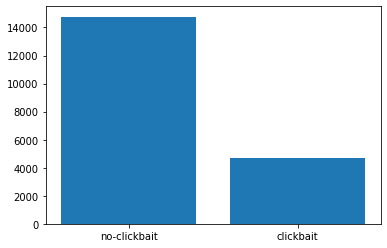

In [8]:
# Plot label distribution 
plt.bar(freqs_target.keys(), freqs_target.values())
plt.show()

Since the dataset is totally imbalanced, let's compute the some class weights to be considered when evaluating the model.

In [9]:
# Create wordcloud

df_train_pos_cl = df_train_cl[df_train_cl['labels'] == 0] # clickbait
df_train_neg_cl = df_train_cl[df_train_cl['labels'] == 1] # No-clickbait

text_pos = " ".join(i for i in df_train_pos_cl.text)
text_neg = " ".join(i for i in df_train_neg_cl.text)

stopwords = set(STOPWORDS)

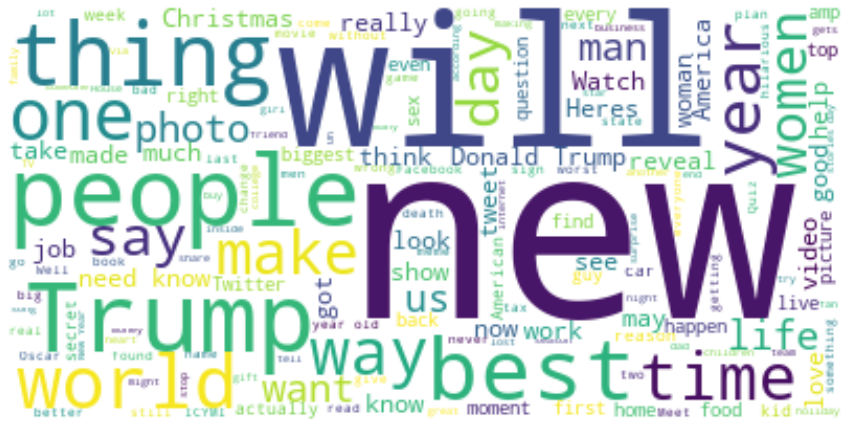

In [10]:
create_wordcloud(text_pos, stopwords=stopwords)

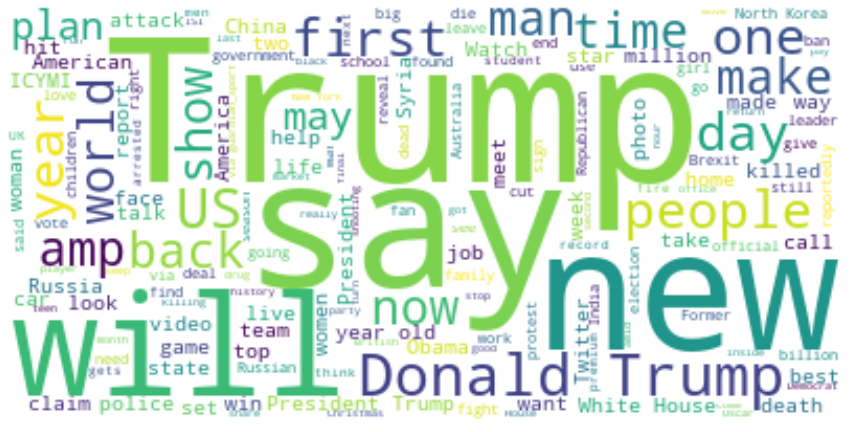

In [11]:
create_wordcloud(text_neg, stopwords=stopwords)

In [12]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(df_train_cl['labels']),
                                                  y=df_train_cl['labels']).tolist()

# Extract Embeddings

In [13]:
# Load English sentence model from SPACY
nlp = spacy.blank('en')
nlp.add_pipe('sentence_bert', config={'model_name': 'allenai-specter'})


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/622 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

In [14]:
# Extract vectors for both training and testing sets
df_train_cl['vector'] = df_train_cl['text'].apply(lambda x: nlp(x).vector)
df_test_cl['vector'] = df_test_cl['text'].apply(lambda x: nlp(x).vector)

In [53]:
# Create train and test sets from the vectors
X_train = np.array(df_train_cl['vector'].tolist())
X_test = np.array(df_test_cl['vector'].tolist())

X_train.shape, X_test.shape

((19484, 768), (18913, 768))

In [16]:
y_train = df_train_cl['labels']
y_test = df_test_cl['labels']

In [17]:
# 1: no-clickbait, 0: clickbait
sample_weight = [class_weights[0] if i == 0 else class_weights[1] for i in y_test]


# Create classifier on top of embeddings

In [18]:
clf = SVC(gamma='auto')

In [19]:
# Train the model
clf.fit(X_train, y_train)

SVC(gamma='auto')

In [20]:
# Make inference for test set
y_pred = clf.predict(X_test)

In [26]:
# Compute classification metrics
print(balanced_accuracy_score(y_true=y_test, y_pred=y_pred, sample_weight=sample_weight))
print(f1_score(y_true=y_test, y_pred=y_pred, sample_weight=sample_weight,
               average='weighted'))
print(recall_score(y_true=y_test, y_pred=y_pred, sample_weight=sample_weight,
                   average='weighted'))

0.6949056484605469
0.6754642878954211
0.6995858170742831


In [28]:
print(classification_report(y_test, y_pred, target_names=['clickbait', 'no-clickbait'],sample_weight=sample_weight,))

              precision    recall  f1-score   support

   clickbait       0.92      0.43      0.58 9209.040712467386
no-clickbait       0.63      0.96      0.77 9535.523429037172

    accuracy                           0.70 18744.564141504557
   macro avg       0.78      0.69      0.67 18744.564141504557
weighted avg       0.77      0.70      0.68 18744.564141504557



# Analyse some of the erros of the model

In [29]:
import random
err_indx = [i for i, pred in enumerate(y_pred) if y_test.values.tolist()[i] == 0 and pred == 1]

In [30]:
test_records = df_test[['text', 'labels']].to_dict('records')
err_test_records = [rec for i, rec in enumerate(test_records) if i in err_indx]
for record in random.sample(err_test_records, k=5):
  print(record)

{'text': 'Where you can stream classic Oscar-winning movies  (via @Watching)', 'labels': 0}
{'text': 'Get excited #WillandGrace fans, the reunion is finally happening!', 'labels': 0}
{'text': "We're all talking about the #Centrelink debt controversy, but what is #robodebt anyway?", 'labels': 0}
{'text': 'Nursing home ASAP', 'labels': 0}
{'text': 'In 100 days, Trump has found 29 ways to screw regular Americans', 'labels': 0}


# Finetune Pre-trained model

## Generate Dataset schema for HuggingFace

In [31]:
# Split train into train + eval
webis_clickbait_train, webis_clickbait_eval = train_test_split(df_train_cl, 
                                                               test_size=0.3,
                                                               stratify=df_train_cl['labels'])
webis_clickbait_train.shape, webis_clickbait_eval.shape

((13638, 4), (5846, 4))

In [32]:
# Convert Pandas to Dataset
tds = Dataset.from_pandas(webis_clickbait_train)
vds = Dataset.from_pandas(webis_clickbait_eval)
ts = Dataset.from_pandas(df_test_cl)
tds, vds, ts

(Dataset({
     features: ['text', 'truthClass', 'labels', 'vector', '__index_level_0__'],
     num_rows: 13638
 }), Dataset({
     features: ['text', 'truthClass', 'labels', 'vector', '__index_level_0__'],
     num_rows: 5846
 }), Dataset({
     features: ['text', 'truthClass', 'labels', 'vector', '__index_level_0__'],
     num_rows: 18913
 }))

In [33]:
# Build Dataset
webis_clickbait_ds = DatasetDict()

webis_clickbait_ds['train'] = tds
webis_clickbait_ds['validation'] = vds
webis_clickbait_ds['test'] = ts

webis_clickbait_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'truthClass', 'labels', 'vector', '__index_level_0__'],
        num_rows: 13638
    })
    validation: Dataset({
        features: ['text', 'truthClass', 'labels', 'vector', '__index_level_0__'],
        num_rows: 5846
    })
    test: Dataset({
        features: ['text', 'truthClass', 'labels', 'vector', '__index_level_0__'],
        num_rows: 18913
    })
})

## Tokenize Data

In [35]:
# Pre-trained Model
model_name: str = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [36]:
def preprocess_function(samples, colname="text"):
    #print(samples[colname][0])
    return tokenizer(samples[colname], truncation=True,padding=True)

In [37]:
# Sanity check
tokenized_sentences_1 = tokenizer(webis_clickbait_ds["train"]["text"][0], truncation=True)
tokenized_sentences_1

{'input_ids': [101, 3884, 3393, 7279, 2003, 3045, 2058, 2070, 1997, 1996, 2931, 7206, 2040, 2514, 2187, 2369, 1999, 2605, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [38]:
# Get tokenized input data
tokenized_webis_clickbait = webis_clickbait_ds.map(preprocess_function, batched=True)
tokenized_webis_clickbait

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'truthClass', 'labels', 'vector', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 13638
    })
    validation: Dataset({
        features: ['text', 'truthClass', 'labels', 'vector', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5846
    })
    test: Dataset({
        features: ['text', 'truthClass', 'labels', 'vector', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 18913
    })
})

In [39]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Fine-tune Pre-trained Model

In [40]:
# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [63]:
# Add Parameters to Trainer object
output_dir="./results"
learning_rate=2e-5
per_device_train_batch_size=16
per_device_eval_batch_size=16
num_train_epochs=2
weight_decay=0.01

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=learning_rate,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    evaluation_strategy="epoch"
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [64]:
# Create trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_webis_clickbait["train"],
    eval_dataset=tokenized_webis_clickbait["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer

In [65]:
# Train the model
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, vector, truthClass. If text, __index_level_0__, vector, truthClass are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13638
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1706


Epoch,Training Loss,Validation Loss
1,0.111800,0.683086
2,0.055400,0.856732


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, vector, truthClass. If text, __index_level_0__, vector, truthClass are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5846
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenize

TrainOutput(global_step=1706, training_loss=0.09222439724563294, metrics={'train_runtime': 342.3056, 'train_samples_per_second': 79.683, 'train_steps_per_second': 4.984, 'total_flos': 324587557670832.0, 'train_loss': 0.09222439724563294, 'epoch': 2.0})

## Evaluate fine-tune model

In [66]:
# Evaluate using testing set
predictions = trainer.predict(tokenized_webis_clickbait["test"])

print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__, vector, truthClass. If text, __index_level_0__, vector, truthClass are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 18913
  Batch size = 16


(18913, 2) (18913,)


In [67]:
# Get class with maximum probability
y_pred_trs = np.argmax(predictions.predictions, axis=-1)

In [68]:
print(balanced_accuracy_score(y_true=y_pred_trs, y_pred=y_pred, sample_weight=sample_weight))
print(f1_score(y_true=y_pred_trs, y_pred=y_pred, sample_weight=sample_weight,
               average='weighted'))
print(recall_score(y_true=y_pred_trs, y_pred=y_pred, sample_weight=sample_weight,
                   average='weighted'))

0.7461120760652551
0.7773956690633737
0.7926075345968875


In [69]:
print(classification_report(y_pred_trs, y_pred, target_names=["clickbait", 'no-clickbait']))

              precision    recall  f1-score   support

   clickbait       0.88      0.46      0.60      4601
no-clickbait       0.85      0.98      0.91     14312

    accuracy                           0.85     18913
   macro avg       0.86      0.72      0.76     18913
weighted avg       0.86      0.85      0.84     18913



In [70]:
# Check samples where the model predicted no-clickbait posts when they were clickbait posts
err_indx = [i for i, pred in enumerate(y_pred_trs) if y_test.values.tolist()[i] == 0 and pred == 1]

test_records = df_test[['text', 'labels']].to_dict('records')
err_test_records = [rec for i, rec in enumerate(test_records) if i in err_indx]

In [71]:
# Show some Error Examples
for record in random.sample(err_test_records, k=5):
  print(record)

{'text': 'Troll tries to test gospel singer Kirk Franklin, and Twitter is loving his clap back.', 'labels': 0}
{'text': "Hell f*cking yes Verizon's new unlimited data plan is a good deal", 'labels': 0}
{'text': 'The untold story of Umerkot, a Pakistani town with 80% Hindus and 20% Muslims till 1965!', 'labels': 0}
{'text': 'People are freaking out because this couple looks legit identical', 'labels': 0}
{'text': "Did Japan's Shinzo Abe give @realDonaldTrump a lesson in diplomacy?", 'labels': 0}


## Conclusion

The Webis Clickbait Corpus 2017 (Webis-Clickbait-17) comprises a large set of Twitter posts from some US news publishers. In addition to the posts, information about the articles linked in the posts are included. 

- There are two different classes: clickbait and no-clickbait and the goal was to detect clickbait tweets using Natural Language Processing techniques.
- The corpus is very imbalanced and thus, using some metrics such as accuracy does not make sense since it will enhance the class with much more samples. Consequently, I decided to use both recall and f1-score as the main metrics to compare the different approaches.
- The main problem I noticed after reviewing the data, si that in many cases the information added in the set of clickbait tweets is very similar as in the valid tweets so that, even a human would made mistakes only analysing the text of the tweet. The use of emoticones, exclamations and other non-alphabetic terms could be valuable in order to improve the classification.
- Two different classifiers were designed: 
  - The first classifier is a naive Support Vector Machine which receives as inputs an embedding vector gathered throughout a Bert-based model. It does not provide very optimistic results since the embedding were computing without any fine-tuning on this task. Moreover, SVM are sometimes limited when the dimension of the problem is high (in this case, the embeddig vectors are of the order of 768 values).
  - The second classifier consists of a Transformer model (distilbert-base-uncased) trained via a fine-tuned fashion in order to improve the ability of the model in this specific downtask. Despite the results are not a breakthrough, they definitely shows improvements in comparison with the non-finetuned approach, and we need to consider that we only trained it for 2-3 epochs and with a limited amount of training samples (transformers are really data-hungry systems).

### Alternatives

Additional approaches to address this problem could be:
- Anomaly Detection techniques, where the goal is to detect events that only occurr few times (as it happens in this dataset, where most of te tweets are totally valid).
- Perform some undersampling or oversampling by either reducing the number of samples of the larger class or bootstrapping samples of the class with lower number of samples (however this approach will not very adequate if then we want to train any Transformer model)